## NOTE: Please view on nbviewer to see plotly charts. 
nbviewer: https://nbviewer.jupyter.org/github/connormca12/Springboard-Projects/blob/master/capstone-2/notebooks/machine_learning.ipynb

# Machine Learning - Amazon Rainforest Image Classification
Capstone Project 2 - Connor McAnuff


## Contents:
- Module Importing
- Create  and load dataset
- Evaluation criteria
- CNN models:
    - base
    - dropout regularization
    - image data augmentation
    - dropout and augment 
    - adam optimizer
    - adam dropout
    - adam augment
    - adam dropout augment
    - transfer learning VGG-16
- Evaluating metrics by tag
- One vs all slash_burn model
- One vs all slash_burn model with histogram equalization

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import shutil

from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import keras
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter, defaultdict

import timeit
import pickle
import glob
from tqdm import tqdm

import cv2
from PIL import Image as pil

Using TensorFlow backend.


### Create dataset

In [2]:
# Set paths to data
PROJ_ROOT = os.path.join(os.pardir)

jpg_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-jpg')
                            + '\\{}' + '.jpg')

jpg_image_path_folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-jpg'))

tif_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-tif-v2')
                            + '\\{}' + '.tif')

tif_image_path_folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-tif-v2'))

image_tags_path = os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train_v2.csv')

save_data_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'processed')
                             + '\\{}')

save_model_path = str(os.path.join(PROJ_ROOT,
                            'models')
                             + '\\{}.h5')

save_history_path = str(os.path.join(PROJ_ROOT,
                            'models', 'histories')
                             + '\\{}.pkl')

save_predictions_path = str(os.path.join(PROJ_ROOT,
                            'models', 'predictions')
                             + '\\{}.pkl')

In [3]:
# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(tag_mapping_csv):
    '''
    Input the raw csv listing image files and their associated tags.
    Output a dictionary that maps tags to integers, and a dictionary
    that maps integers to tags (inverse of first dictionary).
    '''
    
    # create a set of all known tags
    all_tags = set()
    
    for i in range(len(tag_mapping_csv)):
        
        # convert spaced separated tags into an array of tags
        tags = tag_mapping_csv['tags'][i].split(' ')
        
        # add tags to the set of known tags
        all_tags.update(tags)
        
    # convert set of tags to a list to list
    all_tags = list(all_tags)
    
    # order set alphabetically
    all_tags.sort()
    
    # dict that maps tags to integers, and the reverse
    tags_map = {all_tags[i]:i for i in range(len(all_tags))}
    inv_tags_map = {i:all_tags[i] for i in range(len(all_tags))}
    
    return tags_map, inv_tags_map

In [4]:
# create a mapping of filename to a list of tags
def create_file_mapping(tag_mapping_csv):
    '''
    Input the raw csv listing image files and their associated tags.
    Output dictionary with image names as keys and split tags as values.
    '''
    mapping = dict()
    for i in range(len(tag_mapping_csv)):
        
        name, tags = tag_mapping_csv['image_name'][i], tag_mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
        
    return mapping

In [5]:
# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
    '''
    Input list of tags associated with an image and the tag mappings.
    Output an array of 0s and 1s, having 1s where the index of the 1
    matches the index of the mapping dicionary of that tag.
    '''
    # create empty vector
    encoding = np.zeros(len(mapping), dtype='uint8')
    
    # mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
        
    return encoding

In [6]:
# load all images into memory
def make_dataset(path, file_mapping, tag_mapping, image_target_size=(128,128)):
    '''
    Input path to images, file mapping, tag mapping
    Output X and y datasets
    ''' 
    photos, targets = list(), list()
    
    # enumerate files in the directory
    for filename in tqdm(os.listdir(path)):
        
        # load image
        photo = load_img(path + '\\' + filename, target_size=image_target_size)
        
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        
        # get tags
        tags = file_mapping[filename[:-4]]
        
        # one hot encode tags
        target = one_hot_encode(tags, tag_mapping)
        
        # store
        photos.append(photo)
        targets.append(target)
        
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    
    return X, y

In [7]:
# load the mapping file
filename = 'train_v2.csv'
tag_mapping_csv = pd.read_csv(image_tags_path)

# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(tag_mapping_csv)

# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(tag_mapping_csv)

# load the jpeg images
folder = jpg_image_path_folder
X, y = make_dataset(folder, file_mapping, tag_mapping, image_target_size=(128,128))

print('X shape:', X.shape, 'y shape:', y.shape)

# save both arrays to one file in compressed format
#np.savez_compressed(save_data_path.format('processed_data_full.npz'), X, y)

100%|█████████████████████████████████████████████████████| 40479/40479 [01:31<00:00, 440.87it/s]


X shape: (40479, 128, 128, 3) y shape: (40479, 17)


### Load dataset

In [8]:
# load train and test dataset
def load_dataset(dataset_name, test_size=0.3, random_state=42):
    '''
    Input the name of a previously created dataset (e.g. planet_data_5000.npz)
    Split the dataset into train and test sets and return.
    '''
    
    # load dataset
    data = np.load(save_data_path.format(dataset_name))
    X, y = data['arr_0'], data['arr_1']
    
    # separate into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print('X_train shape:', X_train.shape,
          'X_test shape:', X_test.shape,
          'y_train shape:', y_train.shape,
          'y_test shape:', y_test.shape)
    
    return X_train, y_train, X_test, y_test

### Evaluation Criteria

In [9]:
data = np.load(save_data_path.format('processed_data_full.npz'))
X, y = data['arr_0'], data['arr_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# make all one predictions
train_yhat = np.asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
test_yhat = np.asarray([np.ones(y_test.shape[1]) for _ in range(y_test.shape[0])])

In [11]:
train_score = fbeta_score(y_train, train_yhat, 2, average='samples')
test_score = fbeta_score(y_test, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

All Ones: train=0.483, test=0.485


- Must create an fbeta score function that can be used by keras:

In [23]:
# calculate fbeta score for multi-class/label classification
def metric_fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [13]:
# test metric fbeta - ensure result is equal to sk-learn result
train_score = metric_fbeta(backend.variable(y_train), backend.variable(train_yhat)).eval(session=backend.get_session())
test_score = metric_fbeta(backend.variable(y_test), backend.variable(test_yhat)).eval(session=backend.get_session())
print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

All Ones (keras): train=0.483, test=0.485


### CNN Machine Learning

- VGG-type structure:
https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
    - Blocks of convolutional layers with 3x3 filters, followed by max pooling layer - pattern repeats with a doubling of number of filters with each block added.
    - Specifically, each block has two convolutional layers with 3x3 filters, ReLU activation, and He weight initialization (with same padding)
    - Output feature maps have the same width and height 
    - These blocks are followed by a max pooling layer with 2x2 kernel
    - 3 of these blocks are used with 32, 64, and 128 filters
    - Output of final pooling layer is flattened and fed to fully connected layer for interpretation then lastly fed to an output layer for prediction.
    - The model must produce a 17 element vector (17 tags/classes) with a prediction between 0 and 1 for each output tag/class.
    - Sigmoid activation function in the output layer (multi-label classification) and optimize binary cross entropy loss function
    - Model is optimized using mini-batch stochastic gradient descent 
        - Conservative learning rate of 0.01
        - Momentum of 0.9
        - Model keeps track of 'fbeta' metric during training
        
        
- How it works:
     - Convolution layers:
         - Filter of small size is moved across the image and convolution operations are performed
         - Convolutional operations are element-wise matrix multiplication between the filter values and the pixels in the image, with the resultant values being summed
     - Pooling (downsampling) layers:
         - Used to downsample the image
         - Images contain many pixel values, it is typically easier for the network to learn the features if the image size is progressively reduced
         -  Reduces number of parameters and therefore computation
         - Also helps avoid overfitting
         - Max pooling selects maximum value, average pooling (rarely used) takes an average...
         

In [9]:
# define cnn model
def define_model(dropout, adam_opt, in_shape=(128, 128, 3), out_shape=17):
    
    # Initiate model as sequential - will be a linear stack of layers
    model = Sequential()
    
    # Add first block
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Add second block
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Add third block
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Flatten (to 1D vector) and feed to fully connected layer (relu activation)
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.5))
    
    # feed to output layer (sigmoid)
    model.add(Dense(out_shape, activation='sigmoid'))
    
    # Initiate optimization
    if adam_opt == True:
        opt = Adam()
    else:
        opt = SGD(lr=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metric_fbeta])
    
    return model

In [10]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    
    # plot loss
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue')
    ax[0].plot(history.history['val_loss'], color='orange')
    ax[0].legend(['train', 'test'], loc='upper left')
    
    # plot fbeta
    ax[1].set_title('Fbeta')
    ax[1].plot(history.history['fbeta'], color='blue')
    ax[1].plot(history.history['val_fbeta'], color='orange')
    ax[1].legend(['train', 'test'], loc='upper left')
    
    plt.show()

In [11]:
# function for evaluating models
def run_test_harness(dataset_name,
                     model_name,
                     in_shape,
                     epochs,
                     early_stopping=False,
                     dropout=False,
                     augment=False,
                     adam_opt=False,
                     transfer=False):
    
    # load dataset
    X_train, y_train, X_test, y_test = load_dataset(dataset_name)
    
    # create data generator(s)
    if augment == True:
        train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
        test_datagen = ImageDataGenerator(rescale=1.0/255.0)
        
         # prepare iterators
        train_it = train_datagen.flow(X_train, y_train, batch_size=128)
        test_it = test_datagen.flow(X_test, y_test, batch_size=128)
        
        model = define_model(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
        
    elif transfer == False:
        # no augmentation
        datagen = ImageDataGenerator(rescale=1.0/255.0)
        
        # prepare iterators
        train_it = datagen.flow(X_train, y_train, batch_size=128)
        test_it = datagen.flow(X_test, y_test, batch_size=128)
        
        model = define_model(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
    
    else:
        # create data generator for transfer learning
        datagen = ImageDataGenerator(featurewise_center=True)
        # specify imagenet mean values for centering
        datagen.mean = [123.68, 116.779, 103.939]
        
        # prepare iterators
        train_it = datagen.flow(X_train, y_train, batch_size=128)
        test_it = datagen.flow(X_test, y_test, batch_size=128)
        
        model = define_transfer_model(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
    
    # implement early stopping for when validation loss stops decreasing
    if early_stopping == True:
        earlystop = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 30,
                              verbose = 1,
                              restore_best_weights = True)
    
        # fit model
        history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
            validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=0, callbacks=[earlystop])
    
    else:
        # fit model
        history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
            validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
    
    # evaluate model
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    
    # save model
    model.save(save_model_path.format(model_name))
    
    # learning curves
    summarize_diagnostics(history)
    
    # make predictions for test data - needed to include shuffle=False as an argument
    # these predictions are useless - will calculate them again outside of this function
    # predictions = model.predict_generator(test_it, steps=len(test_it), shuffle=False)
    predictions = model.predict_generator(test_it, steps=len(test_it))
    
    return model, history, predictions

In [12]:
def save_data(model_name, history, predictions):

  with open(save_history_path.format(model_name), 'wb') as file:
    pickle.dump(history, file)

  with open(save_predictions_path.format(model_name), 'wb') as file:
    pickle.dump(predictions, file)

In [13]:
def load_model_info(model_name, X_train, y_train, X_test, y_test, augment=False, transfer=False):
    
    model = load_model(save_model_path.format(model_name))
    history = pickle.load(open(save_history_path.format(model_name), 'rb'))
    predictions = pickle.load(open(save_predictions_path.format(model_name), 'rb'))
    
    # create data generator(s)
    if augment == True:
        train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
        test_datagen = ImageDataGenerator(rescale=1.0/255.0)
        
         # prepare iterators
        train_it = train_datagen.flow(X_train, y_train, batch_size=128)
        test_it = test_datagen.flow(X_test, y_test, batch_size=128)
        
    elif transfer == False:
        # no augmentation
        datagen = ImageDataGenerator(rescale=1.0/255.0)
        
        # prepare iterators
        train_it = datagen.flow(X_train, y_train, batch_size=128)
        test_it = datagen.flow(X_test, y_test, batch_size=128, shuffle=False)
    
    else:
        # create data generator for transfer learning
        datagen = ImageDataGenerator(featurewise_center=True)
        # specify imagenet mean values for centering
        datagen.mean = [123.68, 116.779, 103.939]
        
        # prepare iterators
        train_it = datagen.flow(X_train, y_train, batch_size=128)
        test_it = datagen.flow(X_test, y_test, batch_size=128)
    
    loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
    
    #summarize_diagnostics(history)
    
    return model, history, predictions

In [14]:
all_predictions = {}

def model_predict(model, X_test, y_test):
    
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_it = datagen.flow(X_test, y_test, batch_size=128, shuffle=False)
    predictions = model.predict_generator(test_it, steps=len(test_it))
    fbeta_gen = metric_fbeta(backend.variable(y_test), backend.variable(predictions), beta=2).eval(session=backend.get_session())
    print('fbeta=%.3f' % (fbeta_gen))

    return predictions

### Base Model:

Run on Kaggle notebooks fro GPU processing:

In [261]:
'''
start = timeit.default_timer()

dataset_name = 'processed_data_full.npz'
model_name = 'base_model'
in_shape = (128, 128, 3)
base_predictions = run_test_harness(dataset_name,
                                    model_name,
                                    in_shape,
                                    epochs=50,
                                    early_stopping=False,
                                    dropout=False,
                                    augment=False,
                                    adam_opt=False)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)  
'''

In [254]:
# must give keras the fbeta function, otherwise models cannot be loaded in
keras.metrics.fbeta = metric_fbeta

In [247]:
# load dataset
X_train, y_train, X_test, y_test = load_dataset('processed_data_full.npz')

X_train shape: (28335, 128, 128, 3) X_test shape: (12144, 128, 128, 3) y_train shape: (28335, 17) y_test shape: (12144, 17)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

> loss=0.564, fbeta=0.822


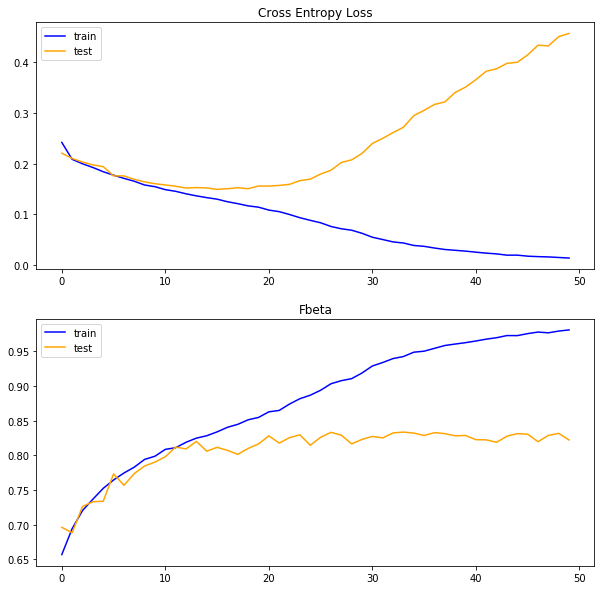

In [24]:
base_model, base_history, _ = load_model_info('base_model', X_train, y_train, X_test, y_test)

In [25]:
base_predictions = model_predict(base_model, y_test)

fbeta=0.822


### Dropout Regularization
- Computationally cheap method to regularize a deep neural network
- Probabilistically remove (i.e. drop out) inputs to a layer
- Effectively simulates a large number of networks with very different structures which makes the modes in a network generally more robust to the inputs
- Avoid overfitting
https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
- Can apply a small amount of dropout after each block - more dropout is applied to the fully connected layers (near the output)

Run on Kaggle notebooks fro GPU processing:

In [262]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'processed_data_full.npz'
model_name = 'dropout_model.h5'
in_shape = (128, 128, 3)
# 200 epochs given that we expect rate of learning to slow with dropout
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 early_stopping=False,
                 dropout=True,
                 augment=False,
                 adam_opt=False)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)
'''

> loss=0.235, fbeta=0.855


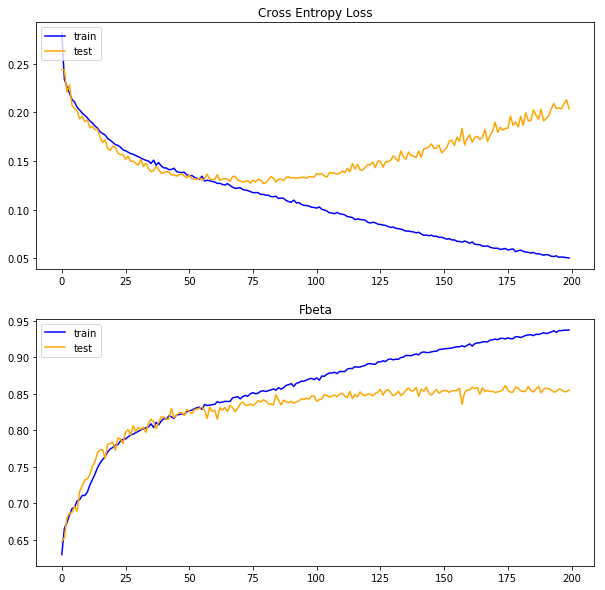

In [27]:
dropout_model, dropout_history, _ = load_model_info('dropout_model', X_train, y_train, X_test, y_test)

In [28]:
dropout_predictions = model_predict(dropout_model, y_test)

fbeta=0.855


### Image Data Augmentation
- Artificially expand size of training dataset by creating modified versions of images in the original dataset
- Can help models ability to generalize
- Can also act as a regularization method
- Can be specified as arguments to the ImageDataGenerator
- Should not be used on test dataset

Run on Kaggle notebooks fro GPU processing:

In [263]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'processed_data_full.npz'
model_name = 'augment_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 early_stopping=False,
                 dropout=False,
                 augment=True,
                 adam_opt=False)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)  
'''

> loss=0.126, fbeta=0.878


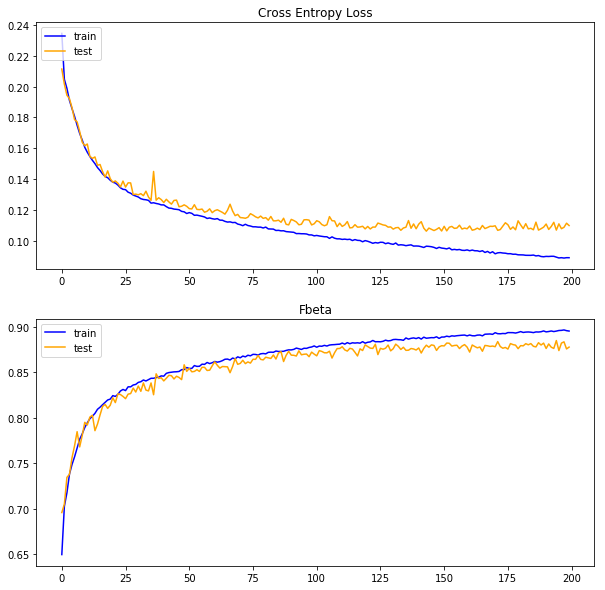

In [30]:
augment_model, augment_history, _ = load_model_info('augment_model', X_train, y_train, X_test, y_test, augment=True)

In [31]:
augment_predictions = model_predict(augment_model, y_test)

fbeta=0.878


### Dropout Regularization and Image Data Augmentation

Run on Kaggle notebooks fro GPU processing:

In [264]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'processed_data_full.npz'
model_name = 'dropout_augment_model.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 early_stopping=True,
                 dropout=True,
                 augment=True,
                 adam_opt=False)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)
'''

> loss=0.121, fbeta=0.840


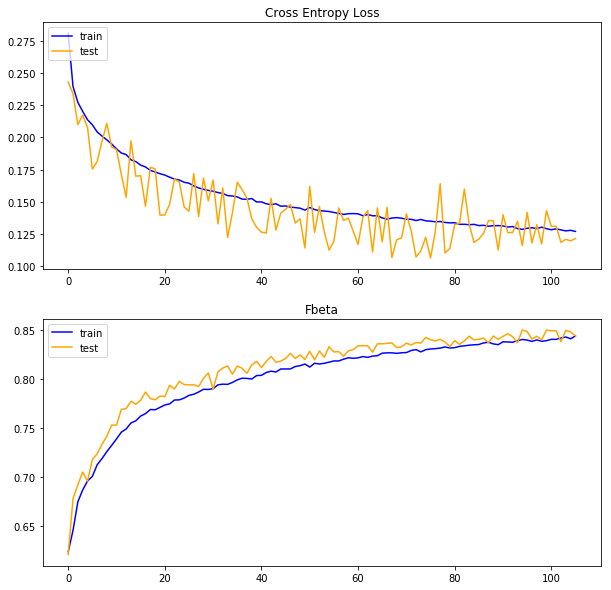

In [33]:
dropout_augment_model, dropout_augment_history, _ = load_model_info('dropout_augment_model', X_train, y_train, X_test, y_test)

In [34]:
dropout_augment_predictions = model_predict(dropout_augment_model, y_test)

fbeta=0.840


### Adam Optimizer
- Used to implement an adaptive learning rate.

Run on Kaggle notebooks fro GPU processing:

In [265]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'planet_data_5000.npz'
model_name = 'adam_model'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=50,
                 early_stopping=False,
                 dropout=False,
                 augment=False,
                 adam_opt=True)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)
'''

> loss=0.711, fbeta=0.845


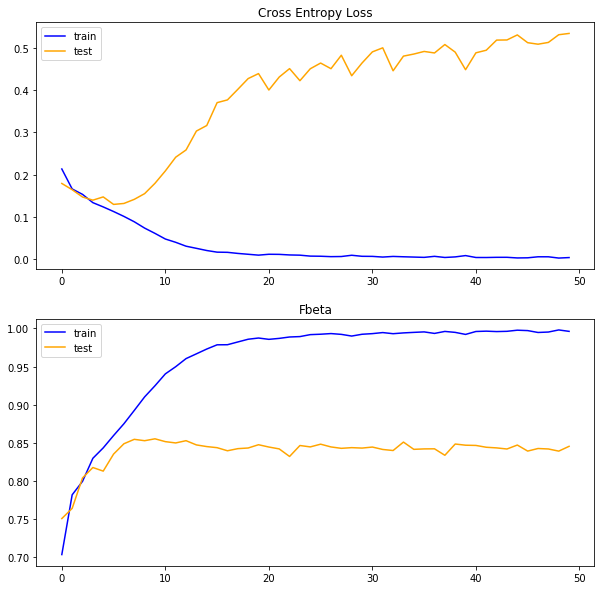

In [36]:
adam_model, adam_history, _ = load_model_info('adam_model', X_train, y_train, X_test, y_test)

In [37]:
adam_predictions = model_predict(adam_model, y_test)

fbeta=0.845


### Adam Optimizer and dropout regularization

Run on Kaggle notebooks fro GPU processing:

In [269]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'planet_data_5000.npz'
model_name = 'adam_dropout_model'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 early_stopping=False,
                 dropout=True,
                 augment=False,
                 adam_opt=True)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)  
'''

> loss=0.391, fbeta=0.862


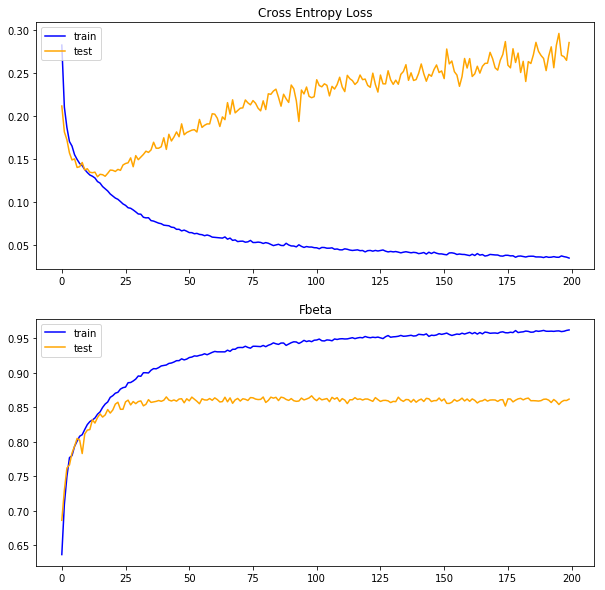

In [39]:
adam_dropout_model, adam_dropout_history, _ = load_model_info('adam_dropout_model', X_train, y_train, X_test, y_test)

In [41]:
adam_dropout_predictions = model_predict(adam_dropout_model, y_test)

fbeta=0.862


### Adam Optimizer and image augmentation

Run on Kaggle notebooks fro GPU processing:

In [268]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'planet_data_5000.npz'
model_name = 'adam_augment_model'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 early_stopping=True,
                 dropout=False,
                 augment=True,
                 adam_opt=True)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)
'''

> loss=0.097, fbeta=0.878


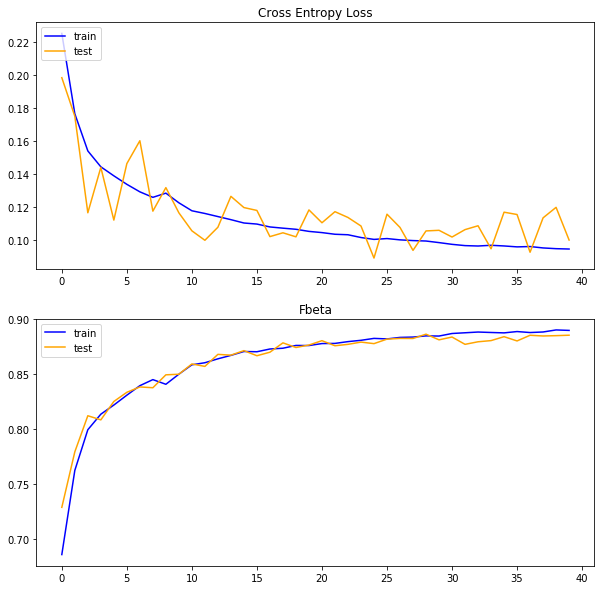

In [43]:
adam_augment_model, adam_augment_history, _ = load_model_info('adam_augment_model', X_train, y_train, X_test, y_test)

In [44]:
adam_augment_predictions = model_predict(adam_augment_model, y_test)

fbeta=0.878


### Adam Optimizer, dropout regularization, and image augmentation

Run on Kaggle notebooks fro GPU processing:

In [267]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'processed_data_full.npz'
model_name = 'adam_dropout_augment_model'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=200,
                 early_stopping=True,
                 dropout=True,
                 augment=True,
                 adam_opt=True)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)
'''

> loss=0.109, fbeta=0.870


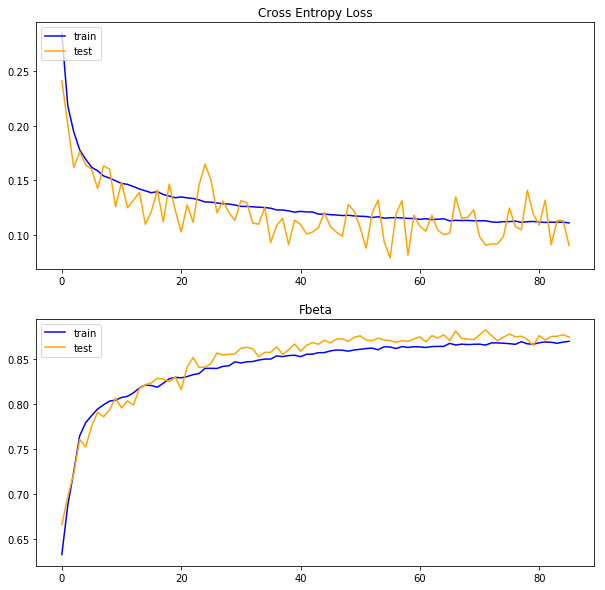

In [46]:
adam_dropout_augment_model, adam_dropout_augment_history, _ = load_model_info('adam_dropout_augment_model', X_train, y_train, X_test, y_test)

In [47]:
adam_dropout_augment_predictions = model_predict(adam_dropout_augment_model, y_test)

fbeta=0.870


### Transfer Learning Model

In [48]:
# Load in VGG-16 model and define new fully connect and output layers
def define_transfer_model(in_shape=(128, 128, 3), out_shape=17):
    # load model
    model = VGG16(include_top=False, input_shape=in_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(out_shape, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    return model

Run on Kaggle notebooks fro GPU processing:

In [266]:
'''
start = timeit.default_timer()

dataset_name = 'processed_data_full.npz'
transfer_model = define_transfer_model()
model_name = 'transfer_model'
in_shape = (128, 128, 3)
transfer_mode, transfer_history, transfer_predictions = run_test_harness(dataset_name,
                                                                         model_name,
                                                                         in_shape,
                                                                         epochs=10,
                                                                         early_stopping=False,
                                                                         dropout=False,
                                                                         augment=False,
                                                                         adam_opt=False,
                                                                         transfer=True)

save_data(model_name, transfer_history, transfer_predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)
'''

In [256]:
transfer_model, transfer_history, _ = load_model_info('transfer_model', X_train, y_train, X_test, y_test, transfer=True)

> loss=0.276, fbeta=0.879


In [257]:
# create data generator for transfer learning
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
        
# prepare iterators
test_it = datagen.flow(X_test, y_test, batch_size=128, shuffle=False)

transfer_predictions = transfer_model.predict_generator(test_it, steps=len(test_it))
fbeta_gen_transfer = metric_fbeta(backend.variable(y_test), backend.variable(transfer_predictions), beta=2).eval(session=backend.get_session())
print('fbeta=%.3f' % (fbeta_gen_transfer))

fbeta=0.879


### Model Comparison

In [52]:
models = ['base_model', 'dropout_model', 'augment_model', 'dropout_augment_model', 'adam_model', 'adam_dropout_model',
         'adam_augment_model', 'adam_dropout_augment_model', 'transfer_model']
validation_loss = [0.596,0.330,0.138,0.121,0.910,0.345,0.104,0.125,0.205]
validation_fbeta = [0.822,0.855,0.878,0.840,0.845,0.862,0.878,0.870,0.879]

model_df = pd.DataFrame({'model': models,
            'validation_loss': validation_loss,
            'validation_fbeta': validation_fbeta})

model_df = model_df.set_index('model', drop=True)
model_df

,validation_loss,validation_fbeta
model,,
base_model,0.596,0.822
dropout_model,0.330,0.855
augment_model,0.138,0.878
dropout_augment_model,0.121,0.840
adam_model,0.910,0.845
adam_dropout_model,0.345,0.862
adam_augment_model,0.104,0.878
adam_dropout_augment_model,0.125,0.870
transfer_model,0.205,0.879


### Metrics by Tag

In [31]:
def calc_metrics_by_tag(model_name, tags_map, y_test, model_predictions, threshold=0.5):
    '''
    Input model name, tags map, y_test data, model predictions, and a desired prediction threshold
    Output precision, recall, fbeta by tag
    '''
    
    # Initialize dicts
    model_precision_by_tag = {}
    model_recall_by_tag = {}
    model_fbeta_by_tag = {}

    # for each tag in tags map
    for tag, tag_idx in tags_map.items():
    
        tp = 0
        fp = 0
        fn = 0
    
        # for each obvservation in y_test count tp, fp, fn
        for i, obv in enumerate(y_test):
            if (obv[tag_idx] == 1) & ((model_predictions[i][tag_idx] > threshold) == 1):
                tp += 1
            elif (obv[tag_idx] == 0) & ((model_predictions[i][tag_idx] > threshold) == 1):
                fp += 1 
            elif (obv[tag_idx] == 1) & ((model_predictions[i][tag_idx] > threshold) == 0):
                fn += 1 
    
        # Calculate precision, recall
        tag_precision = tp / (tp + fp)
        tag_recall =  tp / (tp + fn)
        beta = 2
        bb = beta ** 2
    
        # Calculate fbeta
        if (tag_precision == 0) & (tag_recall == 0):
            tag_fbeta = 0
        else:
            tag_fbeta = (1 + bb) * (tag_precision * tag_recall) / (bb * tag_precision + tag_recall)

        # Fill dicts
        model_precision_by_tag[tag] = tag_precision
        model_recall_by_tag[tag] = tag_recall
        model_fbeta_by_tag[tag] = tag_fbeta
    
    return model_precision_by_tag, model_recall_by_tag, model_fbeta_by_tag

In [57]:
# Get augment_model metrics by tag
tags_map, inv_tags_map = create_tag_mapping(tag_mapping_csv)
augment_model_precision_by_tag, augment_model_recall_by_tag, augment_model_fbeta_by_tag = calc_metrics_by_tag('augment_model', tags_map, y_test, augment_predictions, threshold=0.5)

In [58]:
augment_model_fbeta_by_tag

{'agriculture': 0.8036480686695279,
 'artisinal_mine': 0.5360623781676414,
 'bare_ground': 0.12593283582089554,
 'blooming': 0.05555555555555556,
 'blow_down': 0.04950495049504951,
 'clear': 0.9687935034802784,
 'cloudy': 0.7930809399477806,
 'conventional_mine': 0.4850746268656717,
 'cultivation': 0.45285935085007734,
 'habitation': 0.5964444444444444,
 'haze': 0.567260940032415,
 'partly_cloudy': 0.8780578550832482,
 'primary': 0.9845751959198906,
 'road': 0.802846345581732,
 'selective_logging': 0.18987341772151897,
 'slash_burn': 0,
 'water': 0.5899253016663474}

In [258]:
# Get transfer_model metrics by tag
tags_map, inv_tags_map = create_tag_mapping(tag_mapping_csv)
transfer_model_precision_by_tag, transfer_model_recall_by_tag, transfer_model_fbeta_by_tag = calc_metrics_by_tag('transfer_model', tags_map, y_test, transfer_predictions, threshold=0.5)

In [259]:
transfer_model_fbeta_by_tag

{'agriculture': 0.7855114397470931,
 'artisinal_mine': 0.5684007707129095,
 'bare_ground': 0.23116438356164384,
 'blooming': 0.02197802197802198,
 'blow_down': 0,
 'clear': 0.9547280882078115,
 'cloudy': 0.7961165048543689,
 'conventional_mine': 0.371900826446281,
 'cultivation': 0.47168405365126675,
 'habitation': 0.6090601034421259,
 'haze': 0.603359173126615,
 'partly_cloudy': 0.889951273329043,
 'primary': 0.9803921568627451,
 'road': 0.7899666096587672,
 'selective_logging': 0.15250544662309365,
 'slash_burn': 0,
 'water': 0.7213863514239655}

In [59]:
# plot augment_model precision by tag
data=[go.Bar(x=list(augment_model_precision_by_tag.keys()), y=list(augment_model_precision_by_tag.values()))]
layout=dict(height=600, width=1000, xaxis_title='Tag', yaxis_title='Precision', font=dict(size=15, color='black'))
fig=dict(data=data, layout=layout)
fig = go.Figure(fig)
fig.show()

In [60]:
# plot augment_model recall by tag
data=[go.Bar(x=list(augment_model_recall_by_tag.keys()), y=list(augment_model_recall_by_tag.values()))]
layout=dict(height=600, width=1000, xaxis_title='Tag', yaxis_title='Recall', font=dict(size=15, color='black'))
fig=dict(data=data, layout=layout)
fig = go.Figure(fig)
fig.show()

In [61]:
# plot augment_model fbeta by tag
data=[go.Bar(x=list(augment_model_fbeta_by_tag.keys()), y=list(augment_model_fbeta_by_tag.values()))]
layout=dict(height=600, width=1000, xaxis_title='Tag', yaxis_title='Fbeta', font=dict(size=15, color='black'))
fig=dict(data=data, layout=layout)
fig = go.Figure(fig)
fig.show()

In [26]:
def find_best_threshold(model_name, tags_map, y_test, model_predictions, tag):
    '''
    Input model name, tags map, y_test, predictions, and a tag
    Output the precision, recall, fbeta for the highest fbeta 
    '''
    
    #thresholds = np.arange(0.0001, 0.50001, 0.0001)
    thresholds = np.arange(0.001, 0.5001, 0.001)
    fbeta_best = 0
    threshold_best = 0
    
    # for each threshold 
    for threshold in thresholds:

        # calculate precision, recall, fbeta
        precision, recall, fbeta = calc_metrics_by_tag(model_name, tags_map, y_test, model_predictions, threshold=threshold)
        
        # keep track of best fbeta and the precision and recall
        if fbeta[tag] > fbeta_best:
            fbeta_best = fbeta[tag]
            threshold_best = threshold
            precision_best = precision[tag]
            recall_best = recall[tag]
            
        if threshold == 0.5:
            print(fbeta)
    
    print('tag: {}'.format(tag))
    print('Best threshold: {}'.format(threshold_best))
    print('Best fbeta: {}'.format(fbeta_best))
    
    return threshold_best, precision_best, recall_best, fbeta_best

In [63]:
tags_map, inv_tags_map = create_tag_mapping(tag_mapping_csv)
best_threshold_by_tag = {}

# calculate best threshold for all tags
for tag, idx in tqdm(tags_map.items()):
    
    tags_map = {}
    tags_map[tag] = idx

    threshold_best, precision, recall, fbeta_best = find_best_threshold('augment_model', tags_map, y_test, augment_predictions, tag)
    
    best_dict = {}
    best_dict['threshold'] = threshold_best
    best_dict['precision'] = precision
    best_dict['recall'] = recall
    best_dict['fbeta'] = fbeta_best
    best_threshold_by_tag[tag] = best_dict

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]

tag: agriculture
Best threshold: 0.09
Best fbeta: 0.8835321728926268


  6%|████▉                                                                              | 1/17 [00:07<02:01,  7.59s/it]

tag: artisinal_mine
Best threshold: 0.04
Best fbeta: 0.6739130434782609


 12%|█████████▊                                                                         | 2/17 [00:20<02:18,  9.26s/it]

tag: bare_ground
Best threshold: 0.06999999999999999
Best fbeta: 0.39745627980922094


 18%|██████████████▋                                                                    | 3/17 [00:35<02:34, 11.02s/it]

tag: blooming
Best threshold: 0.05
Best fbeta: 0.34722222222222227


 24%|███████████████████▌                                                               | 4/17 [00:46<02:22, 11.00s/it]

tag: blow_down
Best threshold: 0.09999999999999999
Best fbeta: 0.23972602739726032


 29%|████████████████████████▍                                                          | 5/17 [00:55<02:05, 10.43s/it]

tag: clear
Best threshold: 0.22
Best fbeta: 0.9728023869635071


 35%|█████████████████████████████▎                                                     | 6/17 [01:00<01:36,  8.74s/it]

tag: cloudy
Best threshold: 0.09999999999999999
Best fbeta: 0.8674521354933726


 41%|██████████████████████████████████▏                                                | 7/17 [01:09<01:27,  8.77s/it]

tag: conventional_mine
Best threshold: 0.23
Best fbeta: 0.5590062111801242


 47%|███████████████████████████████████████                                            | 8/17 [01:19<01:20,  8.98s/it]

tag: cultivation
Best threshold: 0.12
Best fbeta: 0.6609747823136944


 53%|███████████████████████████████████████████▉                                       | 9/17 [01:27<01:11,  8.89s/it]

tag: habitation
Best threshold: 0.18000000000000002
Best fbeta: 0.702616741361862


 59%|████████████████████████████████████████████████▏                                 | 10/17 [01:35<01:00,  8.62s/it]

tag: haze
Best threshold: 0.060000000000000005
Best fbeta: 0.7356122890523583


 65%|█████████████████████████████████████████████████████                             | 11/17 [01:44<00:51,  8.58s/it]

tag: partly_cloudy
Best threshold: 0.09
Best fbeta: 0.9235725002206335


 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [01:52<00:42,  8.42s/it]

tag: primary
Best threshold: 0.2
Best fbeta: 0.988839956845475


 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [01:55<00:27,  6.94s/it]

tag: road
Best threshold: 0.23
Best fbeta: 0.8311454504538295


 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [02:02<00:21,  7.03s/it]

tag: selective_logging
Best threshold: 0.16
Best fbeta: 0.40579710144927533


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [02:11<00:15,  7.54s/it]

tag: slash_burn
Best threshold: 0.02
Best fbeta: 0.18248175182481757


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [02:20<00:07,  7.99s/it]

tag: water
Best threshold: 0.11
Best fbeta: 0.7472440944881891


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [02:28<00:00,  7.98s/it]


In [65]:
# extract values into new dicts for plotting
best_fbeta_by_tag = {key:value['fbeta'] for (key,value) in best_threshold_by_tag.items()}
precision_by_tag = {key:value['precision'] for (key,value) in best_threshold_by_tag.items()}
recall_by_tag = {key:value['recall'] for (key,value) in best_threshold_by_tag.items()}

In [66]:
# plot comparison of threshold=0.5 and optimized thresholds
layout=dict(height=600, width=1000, xaxis_title='Tag', yaxis_title='Fbeta', font=dict(size=15, color='black'))
fig=dict(layout=layout)
fig = go.Figure(fig)
fig.add_trace(go.Bar(x=list(augment_model_fbeta_by_tag.keys()), y=list(augment_model_fbeta_by_tag.values()), name='threshold=0.5'))
fig.add_trace(go.Bar(x=list(best_fbeta_by_tag.keys()), y=list(best_fbeta_by_tag.values()), name='threshold=custom'))
fig.show()

In [67]:
layout=dict(height=600, width=1000, xaxis_title='Tag', yaxis_title='Precision', font=dict(size=15, color='black'))
fig=dict(layout=layout)
fig = go.Figure(fig)
fig.add_trace(go.Bar(x=list(augment_model_precision_by_tag.keys()), y=list(augment_model_precision_by_tag.values()), name='threshold=0.5'))
fig.add_trace(go.Bar(x=list(precision_by_tag.keys()), y=list(precision_by_tag.values()), name='threshold=custom'))
fig.show()

In [68]:
layout=dict(height=600, width=1000, xaxis_title='Tag', yaxis_title='Recall', font=dict(size=15, color='black'))
fig=dict(layout=layout)
fig = go.Figure(fig)
fig.add_trace(go.Bar(x=list(augment_model_recall_by_tag.keys()), y=list(augment_model_recall_by_tag.values()), name='threshold=0.5'))
fig.add_trace(go.Bar(x=list(recall_by_tag.keys()), y=list(recall_by_tag.values()), name='threshold=custom'))
fig.show()

### Specialized One-vs-all slash_burn Model

In [38]:
# function to get an image list by tag
def get_image_list_by_tag(df, *tags):
    
    for tag in tags:
    
        images_list = df[df['tags'].str.contains(tag)]#['image_name']
    
        if tag == 'cloudy':
            images_list = df[df['tags'].str.contains(tag)]
            images_list = images_list[~images_list['tags'].str.contains('partly_cloudy')]['image_name']

    return images_list

In [40]:
# get list of slash_burn images
slash_burn_images = get_image_list_by_tag(tag_mapping_csv, 'slash_burn')

# split images into train 
slash_burn_images_train = slash_burn_images.iloc[:-63, :]

# Ensure testing images are not augmented
slash_burn_images_test = slash_burn_images.iloc[-63:, :]

In [42]:
# copying images to new folders
src_dir = jpg_image_path_folder
dst_dir = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'train'))

for image in slash_burn_images_train['image_name']:
    jpgfile = os.path.join(src_dir, '{}.jpg'.format(image))
    shutil.copy(jpgfile, dst_dir)
    
dst_dir = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'test'))
    
for image in slash_burn_images_test['image_name']:
    jpgfile = os.path.join(src_dir, '{}.jpg'.format(image))
    shutil.copy(jpgfile, dst_dir)

In [43]:
slash_burn_images_train_copy = slash_burn_images_train.copy()

# augment train images
for image in slash_burn_images_train_copy['image_name']:
    
    raw_image = cv2.imread(jpg_image_path_folder + '\\{}.jpg'.format(image))

    M = cv2.getRotationMatrix2D((128,128),90,1)
    rotated_90 = cv2.warpAffine(raw_image,M,(256,256))
    
    M = cv2.getRotationMatrix2D((128,128),180,1)
    rotated_180 = cv2.warpAffine(raw_image,M,(256,256))
    
    M = cv2.getRotationMatrix2D((128,128),270,1)
    rotated_270 = cv2.warpAffine(raw_image,M,(256,256))
    
    cv2.imwrite('..\\data\\raw\\slash_burn\\train\\{}_rotated_90.jpg'.format(image), rotated_90)
    cv2.imwrite('..\\data\\raw\\slash_burn\\train\\{}_rotated_180.jpg'.format(image), rotated_180)
    cv2.imwrite('..\\data\\raw\\slash_burn\\train\\{}_rotated_270.jpg'.format(image), rotated_270)
    
    new_image_names = [image + '_rotated_90',image + '_rotated_180',image + '_rotated_270']
    new_image_tags = ['slash_burn placeholder', 'slash_burn placeholder','slash_burn placeholder']
    
    temp_df = pd.DataFrame({'image_name': new_image_names, 'tags':new_image_tags})
    
    slash_burn_images_train = slash_burn_images_train.append(temp_df)

In [44]:
slash_burn_images_train = slash_burn_images_train.reset_index(drop=True)

In [64]:
# fetch random images that are not tagged with slash_burn
random_others_train = tag_mapping_csv.sample(n=584)
for index, row in random_others_train.iterrows():
    
    if 'slash_burn' in row['tags']:
        print('We got a runner!')

In [65]:
# add random images to train dataset
slash_burn_dataset_train = slash_burn_images_train.append(random_others_train)

In [66]:
# copy random images to train dataset folder
src_dir = jpg_image_path_folder
dst_dir = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'train'))

for image in random_others_train['image_name']:
    jpgfile = os.path.join(src_dir, '{}.jpg'.format(image))
    shutil.copy(jpgfile, dst_dir)

In [77]:
# get random images not tagged with slash_burn for test dataset
random_others_test = tag_mapping_csv.sample(n=437)
for index, row in random_others_test.iterrows():
    
    if 'slash_burn' in row['tags']:
        print('We got a runner!')
    
    if row['image_name'] in random_others_train['image_name']:
        print('We got a dup!')

In [78]:
# copy random images to test dataset folder
src_dir = jpg_image_path_folder
dst_dir = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'test'))

for image in random_others_test['image_name']:
    jpgfile = os.path.join(src_dir, '{}.jpg'.format(image))
    shutil.copy(jpgfile, dst_dir)

In [79]:
# add random images to test dataset
slash_burn_dataset_test = slash_burn_images_test.append(random_others_test)

In [80]:
slash_burn_dataset_test = slash_burn_dataset_test.reset_index(drop=True)

In [145]:
# load all images into memory
def make_slash_burn_dataset(path, file_mapping, image_target_size=(128,128)):
    '''
    Input path to images, file mapping, tag mapping
    Output X and y datasets
    ''' 
    photos, targets = list(), list()
    
    count = 0
    
    # enumerate files in the directory
    for filename in tqdm(os.listdir(path)):
        
        # load image
        photo = load_img(path + '\\' + filename, target_size=image_target_size)
        
        # convert to numpy array
        photo = img_to_array(photo, dtype='uint8')
        
        # get tags
        tags = file_mapping[filename[:-4]]
        
        # one hot encode tags
        target = [1 if 'slash_burn' in tags else 0]
        
        # store
        photos.append(photo)
        targets.append(target[0])
        
        if target[0] == 1:
            count += 1
        
        
    print(count)    
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    
    return X, y

In [146]:
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(slash_burn_dataset_train)

# load the jpeg images
folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'train'))

# make train dataset
X_train, y_train = make_slash_burn_dataset(folder, file_mapping, image_target_size=(128,128))

print('X shape:', X_train.shape, 'y shape:', y_train.shape)

# save both arrays to one file in compressed format
np.savez_compressed(save_data_path.format('slash_burn_data_train.npz'), X_train, y_train)

# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(slash_burn_dataset_test)

# load the jpeg images
folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'test'))

# make test dataset
X_test, y_test = make_slash_burn_dataset(folder, file_mapping, image_target_size=(128,128))

print('X shape:', X_test.shape, 'y shape:', y_test.shape)

# save both arrays to one file in compressed format
np.savez_compressed(save_data_path.format('slash_burn_data_test.npz'), X_test, y_test)

100%|███████████████████████████████████████████████████████| 1168/1168 [00:01<00:00, 671.52it/s]


584
X shape: (1168, 128, 128, 3) y shape: (1168,)


100%|█████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 572.95it/s]


63
X shape: (500, 128, 128, 3) y shape: (500,)


In [15]:
# load dataset
data = np.load(save_data_path.format('slash_burn_data_train.npz'))
X_train, y_train = data['arr_0'], data['arr_1']
    
data = np.load(save_data_path.format('slash_burn_data_test.npz'))
X_test, y_test = data['arr_0'], data['arr_1']

Run on Kaggle notebooks fro GPU processing:

In [ ]:
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
start = timeit.default_timer()

dataset_name = 'slash_burn_data.npz'
model_name = 'augment_model_slash_burn.h5'
in_shape = (128, 128, 3)
run_test_harness(dataset_name,
                 model_name,
                 in_shape,
                 epochs=50,
                 early_stopping=True,
                 dropout=False,
                 augment=False,
                 adam_opt=False)

save_data(model_name, history, predictions)

stop = timeit.default_timer()
print('Time: ', (stop - start) / 60)  
'''

In [181]:
augment_model_slash_burn, augment_model_slash_burn_history, augment_model_slash_burn_predictions = load_model_info('augment_model_slash_burn', X_train, y_train, X_test, y_test)

> loss=0.630, fbeta=0.756


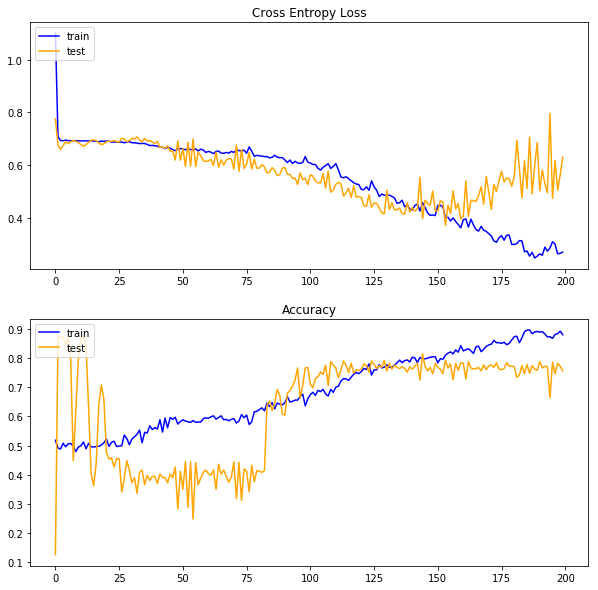

In [182]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

# plot loss
ax[0].set_title('Cross Entropy Loss')
ax[0].plot(augment_model_slash_burn_history.history['loss'], color='blue')
ax[0].plot(augment_model_slash_burn_history.history['val_loss'], color='orange')
ax[0].legend(['train', 'test'], loc='upper left')
    
# plot accuracy
ax[1].set_title('Accuracy')
ax[1].plot(augment_model_slash_burn_history.history['accuracy'], color='blue')
ax[1].plot(augment_model_slash_burn_history.history['val_accuracy'], color='orange')
ax[1].legend(['train', 'test'], loc='upper left')

plt.show()

In [238]:
# new function to get best threshold as output from this model is different than the others
def get_best_thresh_slash_burn(y_test, predictions, thresholds):
    
    best_fbeta = 0
    best_threshold = 0
    
    for threshold in thresholds:
    
        tp = 0
        fp = 0
        fn = 0

        for idx, pred in enumerate(predictions):

            if ((pred > threshold) == 1) & (y_test[idx] == 1):
                tp += 1
            elif ((pred > threshold) == 1) & (y_test[idx] == 0):
                fp += 1
            elif ((pred > threshold) == 0) & (y_test[idx] == 1):
                fn += 1

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        beta = 2
        bb = beta ** 2
        
        if (precision == 0) | (recall == 0):
            fbeta = 0
        else:
            fbeta = (1 + bb) * (precision * recall) / (bb * precision + recall)
        
        if fbeta > best_fbeta:
            best_fbeta = fbeta
            best_precision = precision
            best_recall = recall
            best_threshold = threshold
    
        if threshold == 0.5:
            print('Threshold: ', threshold)
            print('Precision for thr=0.5: ', precision)
            print('Recall for thr=0.5: ', recall)
            print('Fbeta for thr=0.5: ', fbeta)
    
    print('Threshold for best Fbeta: ', best_threshold)
    print('Precision for best Fbeta: ', best_precision)
    print('Recall for best Fbeta: ', best_recall)
    print('Best Fbeta: ', best_fbeta)
    
    return best_threshold, best_precision, best_recall, best_fbeta

In [215]:
thresholds = np.arange(0.001, 0.501, 0.001)
threshold_best, precision_best, recall_best, fbeta_best = get_best_thresh_slash_burn(y_test, augment_model_slash_burn_predictions, thresholds)

Threshold:  0.5
Precision for thr=0.5:  0.31446540880503143
Recall for thr=0.5:  0.7936507936507936
Fbeta for thr=0.5:  0.608272506082725
Threshold for best Fbeta:  0.47700000000000004
Precision for best Fbeta:  0.3128834355828221
Recall for best Fbeta:  0.8095238095238095
Best Fbeta:  0.6144578313253012


In [246]:
get_best_thresh_slash_burn(y_test, np.ones(len(y_test)), thresholds)

Threshold:  0.5
Precision for thr=0.5:  0.126
Recall for thr=0.5:  1.0
Fbeta for thr=0.5:  0.41888297872340424
Threshold for best Fbeta:  0.001
Precision for best Fbeta:  0.126
Recall for best Fbeta:  1.0
Best Fbeta:  0.41888297872340424


(0.001, 0.126, 1.0, 0.41888297872340424)

### slash_burn model with histogram equalization

In [218]:
# Function for rescaling an image (equalization)
def rescale_image(image):
    
    minval, maxval = image.min(), image.max()
    rescaled_image = (255/(maxval - minval) * (image - minval))

    return np.round(rescaled_image).astype('uint8')

In [224]:
# equalize and copy images to new folder
src_dir_equal = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'train'))

dst_dir_equal = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn_equalized',
                            'train'))

for jpgfile in glob.iglob(os.path.join(src_dir_equal, "*.jpg")):
    
    
    raw_image = cv2.imread(jpgfile)
    image_name = jpgfile[29:]
    
    equalized_image = rescale_image(raw_image)
    
    cv2.imwrite(dst_dir_equal + '\\{}'.format(image_name), equalized_image)
    


In [226]:
# equalize and copy images to new folder
src_dir_equal = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn',
                            'test'))

dst_dir_equal = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn_equalized',
                            'test'))

for jpgfile in glob.iglob(os.path.join(src_dir_equal, "*.jpg")):
    
    
    raw_image = cv2.imread(jpgfile)
    image_name = jpgfile[28:]
    
    equalized_image = rescale_image(raw_image)
    
    cv2.imwrite(dst_dir_equal + '\\{}'.format(image_name), equalized_image)

In [227]:
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(slash_burn_dataset_train)

# load the jpeg images
folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn_equalized',
                            'train'))

X_train_sbe, y_train_sbe = make_slash_burn_dataset(folder, file_mapping, image_target_size=(128,128))

print('X shape:', X_train_sbe.shape, 'y shape:', y_train_sbe.shape)

# save both arrays to one file in compressed format
np.savez_compressed(save_data_path.format('slash_burn_equalized_data_train.npz'), X_train_sbe, y_train_sbe)

# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(slash_burn_dataset_test)

# load the jpeg images
folder = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                            'slash_burn_equalized',
                            'test'))

X_test_sbe, y_test_sbe = make_slash_burn_dataset(folder, file_mapping, image_target_size=(128,128))

print('X shape:', X_test_sbe.shape, 'y shape:', y_test_sbe.shape)

# save both arrays to one file in compressed format
np.savez_compressed(save_data_path.format('slash_burn_equalized_data_test.npz'), X_test_sbe, y_test_sbe)

100%|███████████████████████████████████████████████████████| 1168/1168 [00:06<00:00, 192.80it/s]


584
X shape: (1168, 128, 128, 3) y shape: (1168,)


100%|█████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 182.19it/s]


63
X shape: (500, 128, 128, 3) y shape: (500,)


In [228]:
equal_model_slash_burn, equal_model_slash_burn_history, equal_model_slash_burn_predictions = load_model_info('equal_model_slash_burn', X_train_sbe, y_train_sbe, X_test_sbe, y_test_sbe)

> loss=0.465, fbeta=0.864


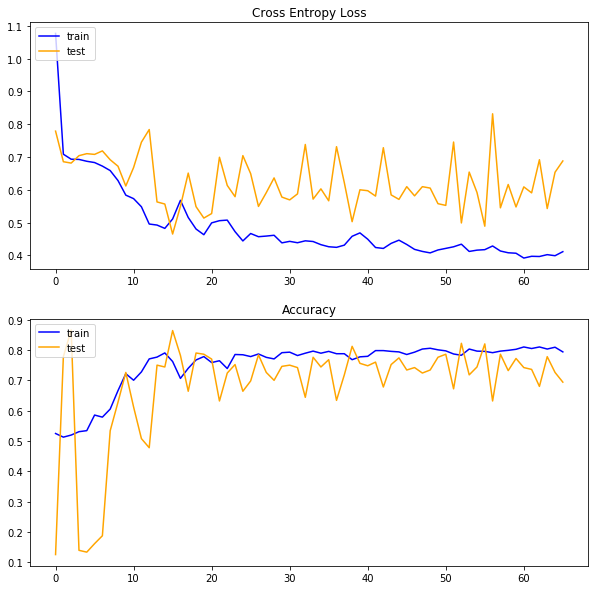

In [229]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

# plot loss
ax[0].set_title('Cross Entropy Loss')
ax[0].plot(equal_model_slash_burn_history.history['loss'], color='blue')
ax[0].plot(equal_model_slash_burn_history.history['val_loss'], color='orange')
ax[0].legend(['train', 'test'], loc='upper left')
    
# plot accuracy
ax[1].set_title('Accuracy')
ax[1].plot(equal_model_slash_burn_history.history['accuracy'], color='blue')
ax[1].plot(equal_model_slash_burn_history.history['val_accuracy'], color='orange')
ax[1].legend(['train', 'test'], loc='upper left')

plt.show()

In [239]:
thresholds = np.arange(0.001, 0.501, 0.001)
threshold_best, precision_best, recall_best, fbeta_best = get_best_thresh_slash_burn(y_test_sbe, equal_model_slash_burn_predictions, thresholds)

Threshold:  0.5
Precision for thr=0.5:  0.0
Recall for thr=0.5:  0.0
Fbeta for thr=0.5:  0
Threshold for best Fbeta:  0.217
Precision for best Fbeta:  0.1671309192200557
Recall for best Fbeta:  0.9523809523809523
Best Fbeta:  0.49099836333878893
